In [173]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [174]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")
from stompy import utils
import stompy.model.delft.dflow_model as dfm
import stompy.model.delft.waq_scenario as dwaq
from stompy.grid import unstructured_grid
from matplotlib import colors
import os
import numpy as np
import xarray as xr
import subprocess
from IPython.display import Video
import six
import glob
from stompy.plot import nbviz

In [360]:
# run_wy2022_bloom_common_20220810:
#   dye1, oakland release, non-temp hydro
# run_wy2022_bloom_common_20220810-v001
#   oakland, eastshore releases. temp hydro.
# run_wy2022_bloom_common_20220810-v002
#   oakland release, temp hydro, 16.62 integration
# run_wy2022_bloom_common_20220810-v003"
#   oakland release in top 2m of water column
# run_wy2022_bloom_common_20220515-v002
#   testing custom tracer
# run_wy2022_bloom_common_20220810-v007
#   age and depth tracers
# run_dir="run_wy2022_bloom_common_20220810-v007" 
#   age and depth tracers for continuous release.
run_dir="run_wy2022_bloom_common_20220805" 


In [361]:
ds=xr.open_dataset(os.path.join(run_dir,"dwaq_map.nc"))

In [178]:
# post process to get
def ratio(a,b,b_min=1e-8):
    return a/b.clip(b_min) * np.where(b<b_min,np.nan, 1.0)

# add some static shots for testing
tidx=-1 # about 12 days
layer=0
conc=ds['Age1Conc'].isel(time=tidx,layer=layer)
age_conc=ds['Age1AConc'].isel(time=tidx,layer=layer)
age_depth_conc=ds['Age1DAConc'].isel(time=tidx,layer=layer)
ds['mean_age']=ratio(age_conc,conc)
ds['mean_depth']=ratio(age_depth_conc, age_conc)

In [231]:
# totally made up numbers to get a bloom over a week, and over
# 100 ug/l
from scipy.integrate import odeint

class Petri:
    I0=100. # insolation
    Isat=10.
    N0=35 # initial DIN
    Nsat=0.5
    Kd=1.0 # light extinction
    kmort=0.15 # per day
    kprod=1.2 # per day, max
    alpha=0.15 # stoichiometry, uM DIN per ug/l chl production.

    def __init__(self,**kw):
        utils.set_keywords(self,kw)
        
    def diff(state,t,Hmean):
        P,N=state
        N=N.clip(0) # no evidence this is really necessary
        P=P.clip(0) # likewise.
        Imean=self.I0*np.exp(-self.Kd*Hmean)
        kLight=Imean/(Imean+self.Isat)
        # duplicate while testing.
        kDIN=N/(N+self.Nsat)
        dgrossP = self.kprod*kLight*kDIN*P
        dnetP = -self.kmort*P + dgrossP
        dN = -self.alpha*dgrossP
        return np.r_[dnetP,dN]

    # t: days
    # c0: phytoplankton as chl ug/l
    # Hmean: meters
    def predict(self, c0, age, Hmean):
        Imean=self.I0*np.exp(-self.Kd*Hmean)
        kLight=Imean/(Imean+self.Isat)
        def diff(state,t):
            P,N=state
            N=N.clip(0)
            P=P.clip(0)
            kDIN=N/(N+self.Nsat)
            dgrossP = self.kprod*kLight*kDIN*P
            dnetP = -self.kmort*P + dgrossP
            dN = -self.alpha*dgrossP
            return np.r_[dnetP,dN]

        age=np.atleast_1d(age)
        if len(age)==1:
            t_vals=np.r_[0,age[0]] # linspace(0,15,200)
        else:
            t_vals=age
        result=odeint(diff,[c0,self.N0],t_vals)
        if len(age)==1:
            return result[-1,:]
        else:
            return result

In [ ]:
grid=unstructured_grid.UnstructuredGrid.read_ugrid(ds)

In [ ]:
frac=0.1
M=grid.smooth_matrix()

In [341]:
def fill(values,iterations=50):
    valid=np.isfinite(values)
    data=np.where(valid,values,0.0)
    weight=np.where(valid,1,0.0)
    for _ in range(iterations):
        data=M.dot(data)
        weight=M.dot(weight)
        data[valid]=values[valid]
        weight[valid]=1.0
    result=np.full(len(values),np.nan)
    valid=weight>1e-4
    result[valid]=data[valid]/weight[valid]
    return result

In [342]:
%timeit fill(predicted[:,0])

41.1 ms ± 9.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
# Is it not taking off b/c...
#   c0 too low relative max productivity?
#   light limitation too strong? I think this is it. Dropping Kd to 0.5 gets
#   bloom front, though
#   it's not nutrient limitation. It's not N0

<IPython.core.display.Javascript object>


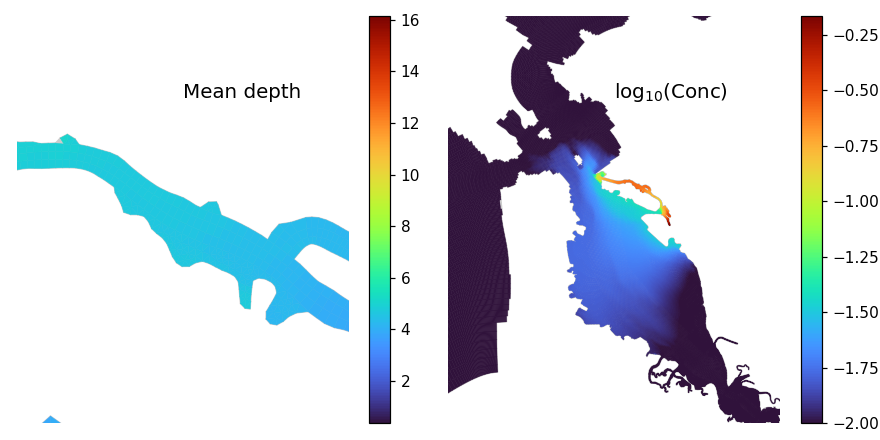

In [359]:
zoom=(534866.147091273, 587089.832126076, 4151509.9875591, 4202696.11593758)

mean_age=ratio(age_conc,conc)
mean_depth=ratio(age_depth_conc, age_conc)
valid=conc.values>=0.008 # covers to just N of DMB, and into Central Bay
H=mean_depth.values

scals=[mean_depth,np.log10(conc.clip(1e-2))]
labels=['Mean depth','log$_{10}$(Conc)']

fig,axs=plt.subplots(1,len(scals),figsize=(8,4))

plt.setp(axs, adjustable='datalim')
for ax in axs:
    ax.axis('off')
fig.tight_layout()
for i,(ax,scal,label) in enumerate(zip(axs,scals,labels)):
    grid.plot_cells(color='0.8',zorder=0,ax=ax)
    ccoll=grid.plot_cells(values=scal,mask=np.isfinite(scal),ax=ax,cmap='turbo',zorder=1,
                          edgecolor='face',lw=0.3)
    ax.axis(zoom)
    plt.colorbar(ccoll,ax=ax)

    ax.text(0.5,0.8,label,transform=ax.transAxes,fontsize=13)


INFO:utils:234/744
INFO:utils:508/744


<IPython.core.display.Javascript object>


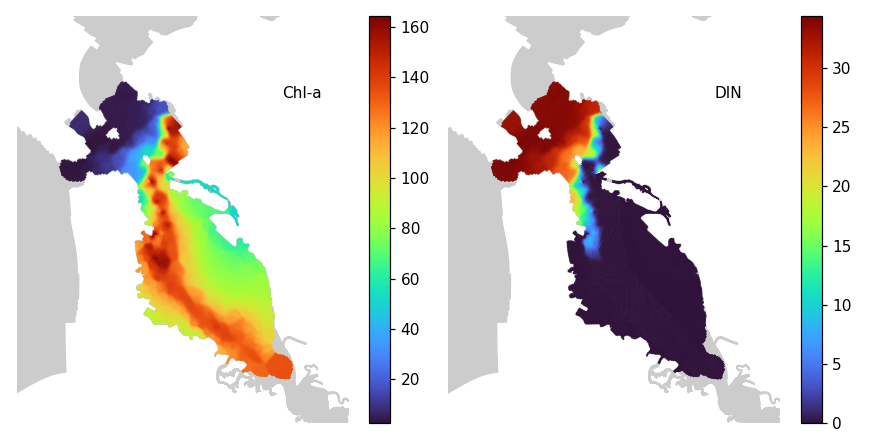

Text(0.8, 0.8, 'DIN')

In [354]:
source_strength=100 # tracer release is unit concentration. scale up to get source ug/l

mean_age=ratio(age_conc,conc)
mean_depth=ratio(age_depth_conc, age_conc)
#petri=Petri(Kd=1.0)
#petri=Petri(Kd=0.5)
#petri=Petri(Isat=1.5)
petri=Petri(Kd=0.4)

valid=conc.values>=0.008 # covers to just N of DMB, and into Central Bay
idxs=np.nonzero( valid)[0]
# select a random subset of idxs to actually simulate
idxs=idxs[np.random.random(len(idxs))<0.04]
c0=source_strength * conc.values
# no need to trust the real age tracer, which has some noise in it.
age=(ds.time.values[tidx] - ds.time.values[0])/np.timedelta64(1,'D') * np.ones_like(c0)
H=mean_depth.values

predicted=np.full((ds.dims['face'],2),np.nan,np.float64)
for idx in utils.progress(idxs):
    predicted[idx] = petri.predict(c0[idx],age[idx],H[idx])

predicted[:,0]=fill(predicted[:,0])
predicted[:,1]=fill(predicted[:,1])


fig,axs=plt.subplots(1,2,figsize=(8,4))
plt.setp(axs, adjustable='datalim')
for ax in axs:
    ax.axis('off')
fig.tight_layout()
for i,ax in enumerate(axs):
    grid.plot_cells(color='0.8',zorder=0,ax=ax)
    scal=predicted[:,i]
    ccoll=grid.plot_cells(values=scal,mask=np.isfinite(scal),ax=ax,cmap='turbo',zorder=1,
                          edgecolor='face',lw=0.3)
    
    ax.axis(zoom)
    plt.colorbar(ccoll,ax=ax)

axs[0].text(0.8,0.8,"Chl-a",transform=axs[0].transAxes)
axs[1].text(0.8,0.8,"DIN",transform=axs[1].transAxes)

<IPython.core.display.Javascript object>


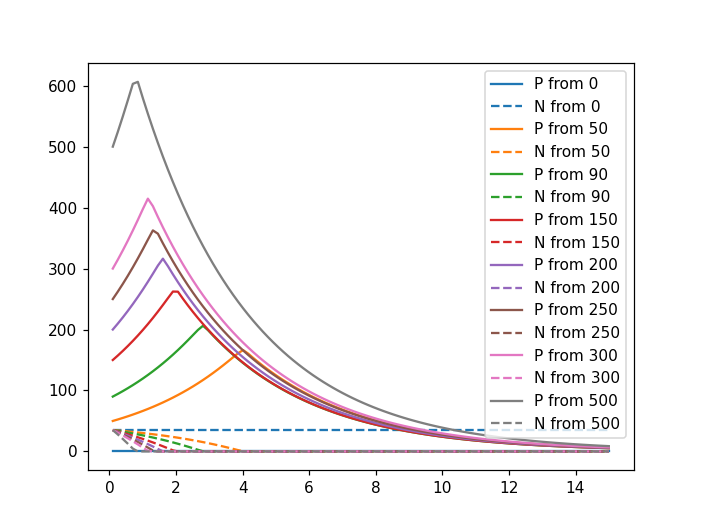

In [240]:
# Am I not getting any variability w.r.t. non-age parameters?
# It's oddly insensitive to initial concentration.
# high initial concentration allows exponential accumulation 
# biomass
c0s=np.linspace(0,200,200)


#    I0=100. # insolation
#    Isat=10.
#    N0=35 # initial DIN
#    Nsat=0.5
#    Kd=1.0 # light extinction
#    kmort=0.15 # per day
#    kprod=1.2 # per day, max
#    alpha=0.15 # stoichiometry, uM DIN per ug/l chl production.

petri=Petri(kmort=0.3,kprod=4,Nsat=0.2)

fig,ax=plt.subplots()

ages=np.linspace(0.1,15,100)

for c0 in [0,50,90,150,200,250,300,500]:
    results = petri.predict(c0,ages,4.0)
    l=ax.plot(ages,results[:,0],label=f'P from {c0}')
    ax.plot(ages,results[:,1],label=f'N from {c0}',color=l[0].get_color(),ls='--')
ax.legend()

# Seems like by having higher initial P, should exhaust nutrients sooner,
# die off sooner. 
# but both growth and depth are essentially exponential. 
# ending P goes up

<IPython.core.display.Javascript object>


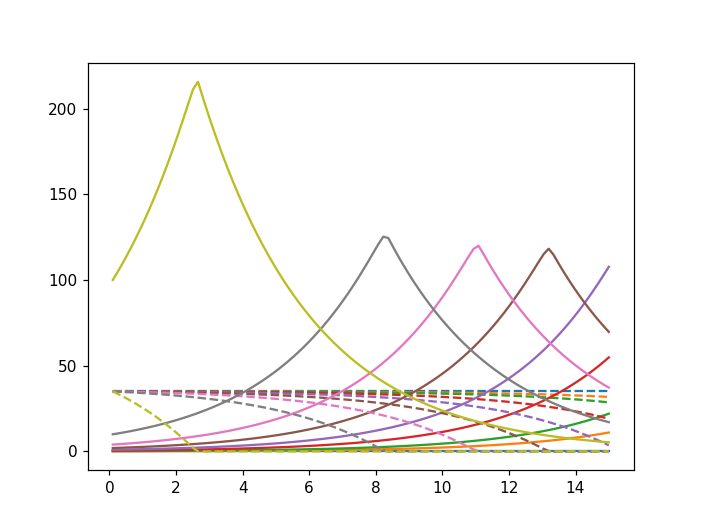

In [301]:
# Am I not getting any variability w.r.t. non-age parameters?
# It's oddly insensitive to initial concentration.
# high initial concentration allows exponential accumulation 
# biomass
c0s=np.linspace(0,200,200)


#    I0=100. # insolation
#    Isat=10.
#    N0=35 # initial DIN
#    Nsat=0.5
#    Kd=1.0 # light extinction
#    kmort=0.15 # per day
#    kprod=1.2 # per day, max
#    alpha=0.15 # stoichiometry, uM DIN per ug/l chl production.

petri=Petri(kmort=0.3,kprod=4,Nsat=0.2)

fig,ax=plt.subplots()

ages=np.linspace(0.1,15,100)

for c0 in [0,0.1,0.2,0.5,1,2,4,10,100]:
    results = petri.predict(c0,ages,4.0)
    l=ax.plot(ages,results[:,0],label=f'P from {c0}')
    ax.plot(ages,results[:,1],label=f'N from {c0}',color=l[0].get_color(),ls='--')
#ax.legend()


In [363]:
viz.datasets

In [364]:
viz.datasets[0].var_dims('Age1Conc')

('time', 'layer', 'face')

<IPython.core.display.Javascript object>


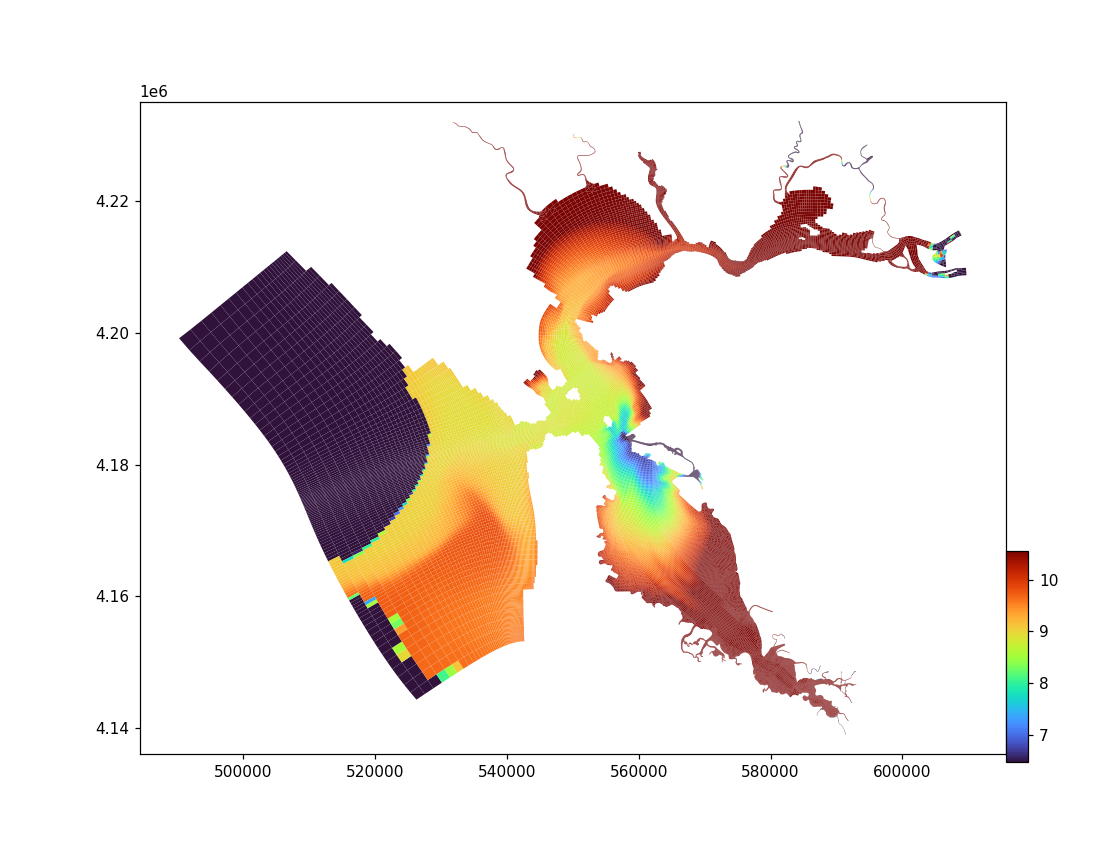

NBViz(children=(VBox(children=(Label(value='Coordinates'),), layout=Layout(grid_area='header')), Select(descri…

Will update/create coordinate pane
set_variable:  age
init_local_dims age
Pre-plot
End of set_variable


In [371]:
six.moves.reload_module(nbviz)
viz=nbviz.NBViz([ds])
# dev: eventually automate more of this.
def age_func(src,dims):
    thresh=1e-5
    age_conc=src('Age1AConc',dims)
    conc=src('Age1Conc',dims)
    age=np.full(conc.shape,0.0)    
    return src('Age1AConc',dims) / src('Age1Conc',dims).clip(1e-5)

viz.datasets[0].expressions.append(
    nbviz.BoundExpression(name='age',dims=['time','layer','face'],func=age_func)
)

viz

Thinking about why starting concentration does not strongly affect ending concentration when there is limitation.


In [243]:
from sympy import *
from sympy.solvers.ode.systems import dsolve_system
init_printing()

In [245]:
P0,N0,t,g,m = symbols("P0,N0,t,g,m")
P=Function('P')
N=Function('N')

In [259]:
eqP=Equality( diff(P(t),t) , (g-m)*P(t))
eqN=Equality( diff(N(t),t) , -g*P(t))
eqP,eqN

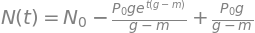

In [270]:
PNsol=dsolve_system([eqP,eqN],[P(t),N(t)],t,ics={P(0):P0,N(0):N0})
assert len(PNsol)==1
Psol,Nsol=PNsol[0]
display(Psol)
display(Nsol)

In [279]:
# nutrient exhausted at t1
t1=solve(Nsol.rhs,t)[0]
t1

In [280]:
P1=Psol.rhs.subs(t,t1)
P1

In [285]:
T=symbols('T')
P2sol=dsolve(eqP.subs(g,0), P(t), ics={P(0):P1}).subs(t,T-t1)
P2sol

In [290]:
P2=P2sol.rhs
P2.simplify()

This simplifies to some degree:

$$P(t) = \left(P_0 + \frac{g-m}{g} N_0 \right) 
  e^{-mT}  
  \left[ \frac{N_0}{P_0} \frac{g-m}{g} + 1 \right]^{\frac{m}{g-m}}
$$

or

$$P(t) = P_0 \left(1 + \frac{g-m}{g} \frac{N_0}{P_0} \right) 
  e^{-mT}  
  \left[ \frac{N_0}{P_0} \frac{g-m}{g} + 1 \right]^{\frac{m}{g-m}}
$$

Does this make sense: collapses well for N0=0
    
What I "wanted" was for a small P0 to allow for a later bloom.

in that case I want P0 to be small relative to N0.
And I guess that happens, but it's a muted effect maybe because the exponent on the last term

<IPython.core.display.Javascript object>


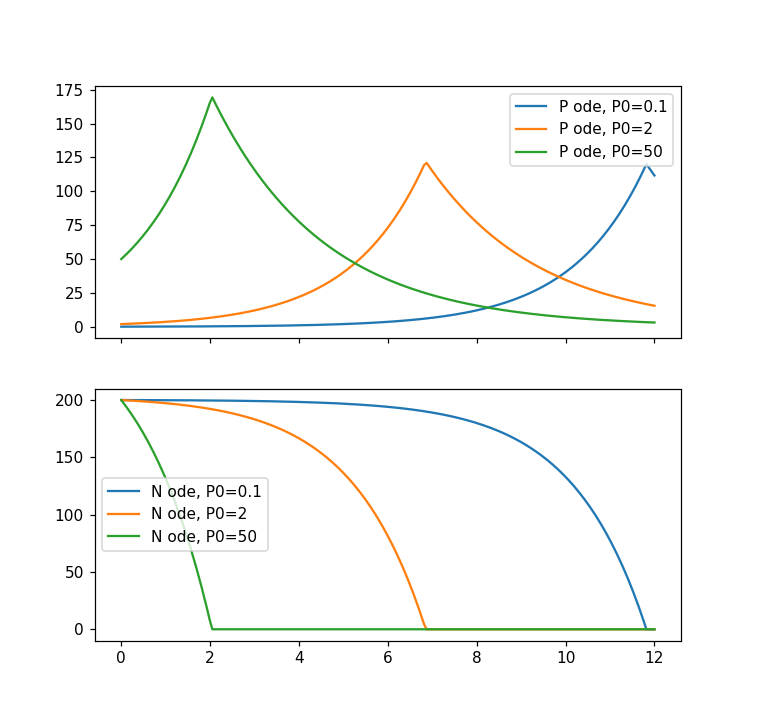

In [296]:
# Make sure this aligns with the ODE results
T=12
t=np.linspace(0,T,200)

m=0.4
g=1.0

def dNP(state,t):
    P,N=state
    kDIN=1*(N>0)
    dgrossP = g*kDIN*P
    dnetP = -m*P + dgrossP
    dN = -dgrossP
    return np.r_[dnetP,dN]

P0s=[0.1,2,50]

fig,(axP,axN)=plt.subplots(2,1,sharex=True)

petri=Petri(N0=200,alpha=1.0)
for P0 in P0s:
    results=odeint(dNP,[P0,200],t)
    axP.plot(t,results[:,0],label=f'P ode, P0={P0}')
    axN.plot(t,results[:,1],label=f'N ode, P0={P0}')
    
axP.legend()
axN.legend()